In [1]:
import sys
sys.path.append("..")
sys.path.append("../main")

import matplotlib.pyplot as plt
import numpy as np
import torch
import bbobtorch
import torch
import model
import gt_sampling
import torch.optim as optim
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils.utils import plot_simulated_meshgrid, plot_collage, plot_ground_truth

In [2]:
# create ground truth functions
n_dim = 2
samples = 1000
seed = 42

def create_problem(f_number, n_dim, seed):
    if f_number == 1:
        problem = bbobtorch.create_f01(n_dim, seed=seed)
    elif f_number == 3:
        problem = bbobtorch.create_f03(n_dim, seed=seed)
    elif f_number == 24:
        problem = bbobtorch.create_f24(n_dim, seed=seed)

    return problem

problem_f01 = create_problem(1, n_dim, seed)
problem_f03 = create_problem(3, n_dim, seed)
problem_f24 = create_problem(24, n_dim, seed)

c:\Users\User\.conda\envs\MachineLearningProject\lib\site-packages\bbobtorch\utils.py:44: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:2431.)
  R, _ = t.qr(R)


In [3]:
# sampling from groundtruth functions
sample_f01 = gt_sampling.get_sample(problem_f01, n_samples=samples, n_dim=2, seed=42, method='random')
sample_f03 = gt_sampling.get_sample(problem_f03, n_samples=samples, n_dim=2, seed=42, method='random')
sample_f24 = gt_sampling.get_sample(problem_f24, n_samples=samples, n_dim=2, seed=42, method='random')

KeyboardInterrupt: 

In [ ]:
data = sample_f24
problem = problem_f24
X_input = torch.tensor(data[0], dtype=torch.float32).clone().detach()
X_input_grad1 = torch.tensor(np.concatenate((X_input, data[2]), axis=1), dtype=torch.float32).clone().detach()
X_input_grad2 = torch.tensor(np.concatenate((X_input, data[2], data[3]), axis=1), dtype=torch.float32).clone().detach()
y_input = data[1].float()            

In [ ]:
input_dim0 = 2
input_dim1 = 4
input_dim2 = 6
hidden_dim = 64
hidden_layers = 2
output_dim = 1
learning_rate = 0.001
num_epochs = 2000
activation = torch.nn.Sigmoid()

m1 = model.NN_norm(input_dim0, hidden_dim, hidden_layers, activation=activation)
m2 = model.NN_norm(input_dim1, hidden_dim, hidden_layers, activation=activation)
m3 = model.NN_norm(input_dim2, hidden_dim, hidden_layers, activation=activation)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(m1.parameters(), lr=learning_rate)
optimizer = optim.Adam(m2.parameters(), lr=learning_rate)
optimizer = optim.Adam(m3.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

In [ ]:
# Training loop for m1
for epoch in range(num_epochs):
    # Forward pass
    outputs = m1(X_input)
    loss = criterion(outputs.flatten(), y_input.unsqueeze(1).flatten()/400)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_lr()[0]:.6f}')

# Training loop for m2
for epoch in range(num_epochs):
    # Forward pass
    outputs = m2(X_input_grad1)
    loss = criterion(outputs.flatten(), y_input.unsqueeze(1).flatten()/400)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_lr()[0]:.6f}')

# Training loop for m3
for epoch in range(num_epochs):
    # Forward pass
    outputs = m3(X_input_grad2)
    loss = criterion(outputs.flatten(), y_input.unsqueeze(1).flatten()/400)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Learning Rate: {scheduler.get_lr()[0]:.6f}')

Epoch [10/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [20/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [30/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [40/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [50/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [60/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [70/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [80/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [90/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [100/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [110/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [120/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [130/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [140/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [150/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [160/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [170/2000], Loss: 0.4693, Learning Rate: 0.001000
Epoch [180/2000], Loss: 0.4693, Learning Rate: 0.001000
E

In [ ]:
class NNEnsemble():
    def __init__(self, models:list, weights:list):
        self.models = models
        self.weights = weights

    def predict(self, X):
        res = [model(X[:,0:2*(i+1)]).numpy() for i, model in  enumerate(self.models)]
        return np.average(res, axis=0, weights=self.weights)

In [ ]:
ensemble = NNEnsemble(models=[m1,m2,m3], weights=[0.9, 0.09, 0.01])

In [ ]:
# generate mesh grid for plotting
with torch.no_grad():
    x = np.linspace(-5.0, 5.0, 100)
    y = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(x, y)
    
    gradients_x = np.zeros_like(X)
    gradients_y = np.zeros_like(Y)

    gradients2_x = np.zeros_like(X)
    gradients2_y = np.zeros_like(Y)

    # Iterate through each point in the mesh grid and compute gradients
    for i in tqdm(range(X.shape[0])):
        for j in range(X.shape[1]):
            gradients_x[i, j], gradients_y[i, j] = gt_sampling.get_gradient(problem, torch.tensor(np.array([X[i, j], Y[i, j]]).reshape((1, 2)), dtype=torch.float32))
            gradients2_x[i, j], gradients2_y[i, j] = gt_sampling.get_second_derivative(problem, torch.tensor(np.array([X[i, j], Y[i, j]]).reshape((1, 2)), dtype=torch.float32))
            
    mesh_samples = np.c_[X.ravel(), Y.ravel(), gradients_x.ravel(), gradients_y.ravel(), gradients2_x.ravel(), gradients2_y.ravel()]
    mesh_samples1 = np.c_[X.ravel(), Y.ravel()]
    mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
    mesh_samples_tensor1 = torch.tensor(mesh_samples1, dtype=torch.float32)
    mesh_results = ensemble.predict(mesh_samples_tensor).reshape(X.shape)
    mesh_results1 = m1(mesh_samples_tensor1).reshape(X.shape)
    mesh_results2 = m2(mesh_samples_tensor[:, 0:4]).reshape(X.shape)
    mesh_results3 = m3(mesh_samples_tensor).reshape(X.shape)

100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


<Axes: title={'center': 'Simulated Function from NN'}, xlabel='X1', ylabel='X2'>

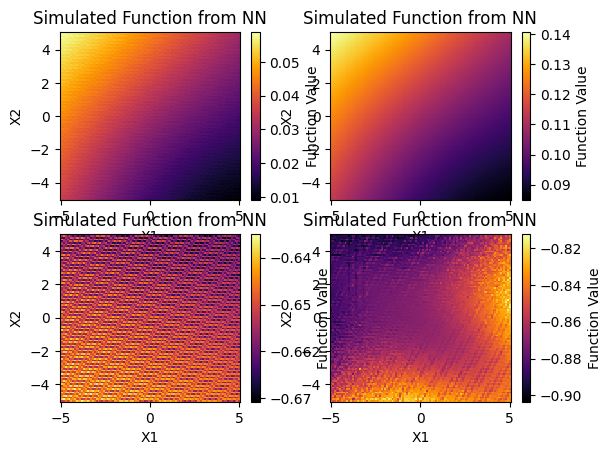

In [ ]:
plt.subplot(221)
plot_simulated_meshgrid(X, Y, mesh_results, model='NN')
plt.subplot(222)
plot_simulated_meshgrid(X, Y, mesh_results1, model='NN')
plt.subplot(223)
plot_simulated_meshgrid(X, Y, mesh_results2, model='NN')
plt.subplot(224)
plot_simulated_meshgrid(X, Y, mesh_results3, model='NN')

<Axes: title={'center': 'Ground Truth of BBOB F24 Function'}, xlabel='X', ylabel='Y'>

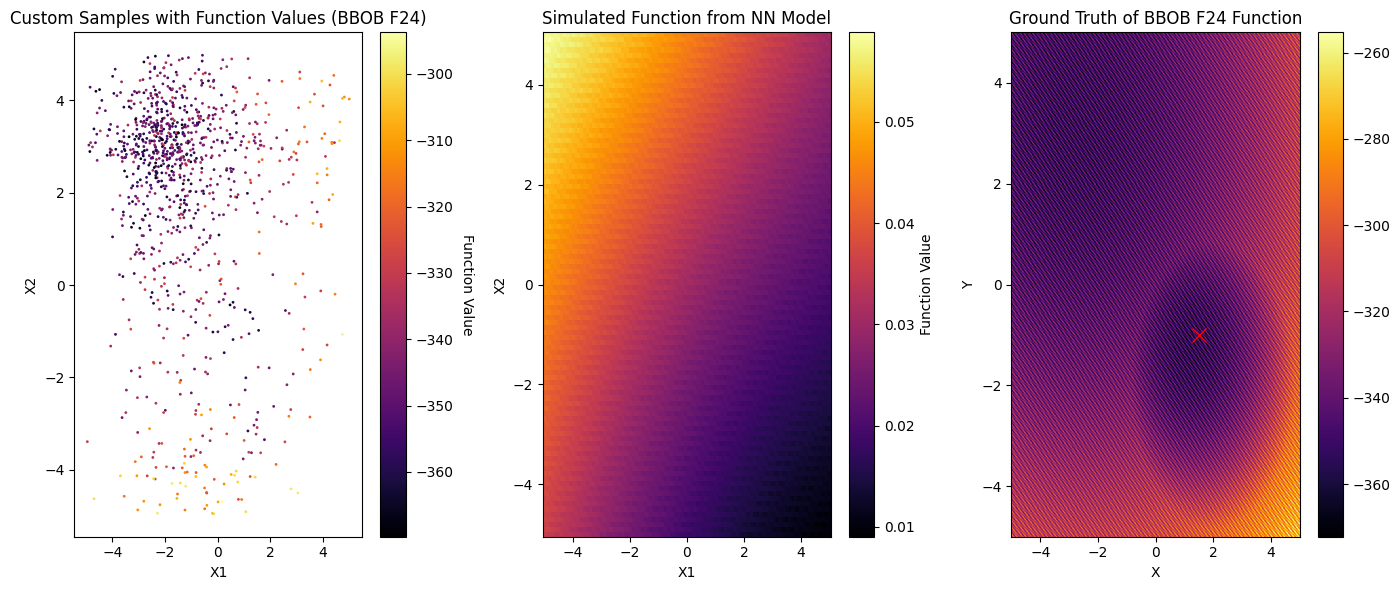

In [ ]:
plot_collage(sample_f24[0], sample_f24[1], problem_f24, "BBOB F24", X, Y, mesh_results)

The same but better (with SVR)

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from copy import deepcopy

In [ ]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVR(kernel='rbf', C=10, gamma=0.6)),
])

In [ ]:
svr1 = deepcopy(pipe)
svr2 = deepcopy(pipe)
svr3 = deepcopy(pipe)

In [ ]:
svr1.fit(X_input, y_input)
svr2.fit(X_input_grad1, y_input)
svr3.fit(X_input_grad2, y_input);

In [ ]:
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)

gradients_x = np.zeros_like(X)
gradients_y = np.zeros_like(Y)

gradients2_x = np.zeros_like(X)
gradients2_y = np.zeros_like(Y)

# Iterate through each point in the mesh grid and compute gradients
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        gradients_x[i, j], gradients_y[i, j] = gt_sampling.get_gradient(problem, torch.tensor(np.array([X[i, j], Y[i, j]]).reshape((1, 2)), dtype=torch.float32))
        gradients2_x[i, j], gradients2_y[i, j] = gt_sampling.get_second_derivative(problem, torch.tensor(np.array([X[i, j], Y[i, j]]).reshape((1, 2)), dtype=torch.float32))
        
mesh_samples = np.c_[X.ravel(), Y.ravel(), gradients_x.ravel(), gradients_y.ravel(), gradients2_x.ravel(), gradients2_y.ravel()]
mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
mesh_results1 = svr1.predict(mesh_samples_tensor[:, 0:2]).reshape(X.shape)
mesh_results2 = svr2.predict(mesh_samples_tensor[:, 0:4]).reshape(X.shape)
mesh_results3 = svr3.predict(mesh_samples_tensor).reshape(X.shape)

In [ ]:
class SVREnsemble():
    def __init__(self, models:list, weights:list):
        self.models = models
        self.weights = weights

    def predict(self, X):
        res = [model.predict(X[:,0:2*(i+1)]) for i, model in enumerate(self.models)]
        return np.average(res, axis=0, weights=self.weights)

In [ ]:
svr_ensemble = SVREnsemble(models=[svr1, svr2, svr3], weights=[0.3, 0.5, 0.2])
mesh_results = svr_ensemble.predict(mesh_samples_tensor).reshape(X.shape)

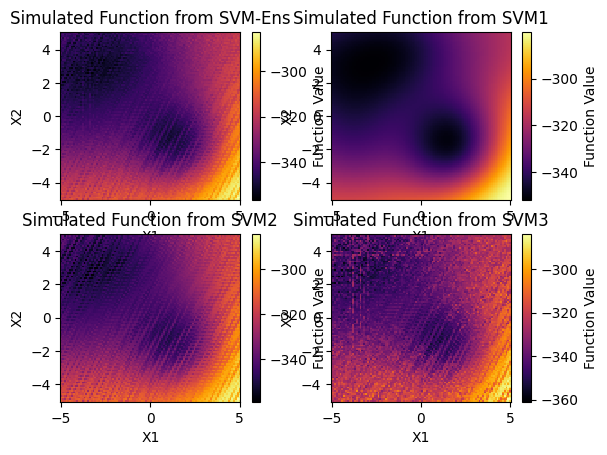

In [ ]:
plt.subplot(221)
plot_simulated_meshgrid(X, Y, mesh_results, model='SVM-Ens')
plt.subplot(222)
plot_simulated_meshgrid(X, Y, mesh_results1, model='SVM1')
plt.subplot(223)
plot_simulated_meshgrid(X, Y, mesh_results2, model='SVM2')
plt.subplot(224)
plot_simulated_meshgrid(X, Y, mesh_results3, model='SVM3')
plt.show()

c:\Users\User\.conda\envs\MachineLearningProject\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


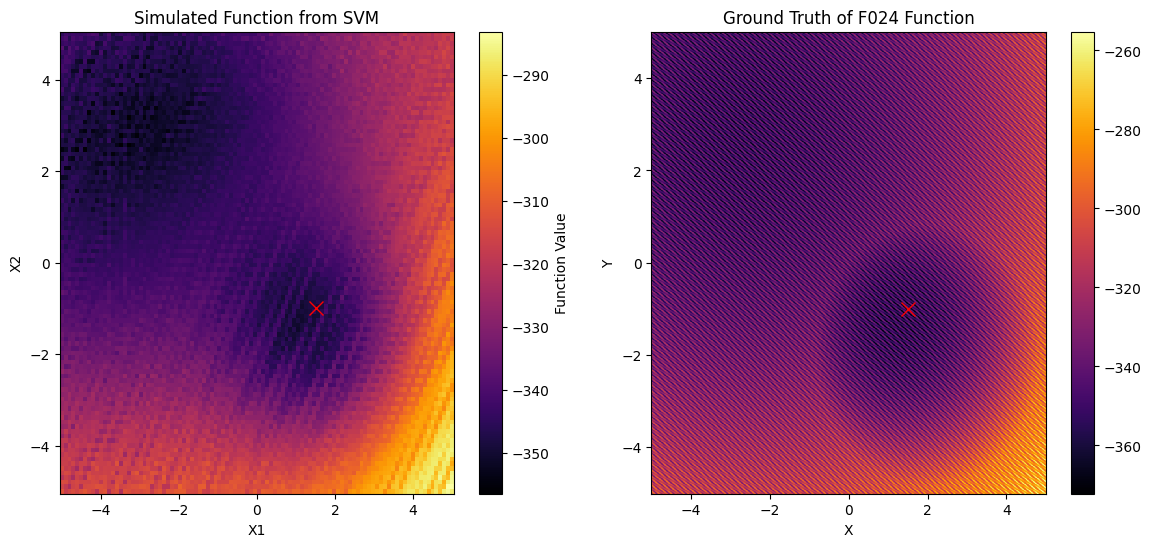

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(121)
plot_simulated_meshgrid(X, Y, mesh_results, model='SVM')
plt.plot(problem.x_opt[0], problem.x_opt[1], 'rx', markersize=10, label='x_opt')
plt.subplot(122)
plot_ground_truth(n_dim, problem, "F024")
plt.show()

## SVM with masked gradients

In [ ]:
svr1 = deepcopy(pipe)
svr2 = deepcopy(pipe)
svr3 = deepcopy(pipe)

In [ ]:
data = sample_f24
problem = problem_f24
X_input = torch.tensor(data[0], dtype=torch.float32).clone().detach()
X_input_grad1 = torch.tensor(np.concatenate((X_input, data[2]), axis=1), dtype=torch.float32).clone().detach()
X_input_grad2 = torch.tensor(np.concatenate((X_input, data[2], data[3]), axis=1), dtype=torch.float32).clone().detach()
y_input = data[1].float()            

In [ ]:
# replace XX% of the data randomly with 0 in X_input_grad1
percentage = 0.75
X_input_grad1[np.random.choice(X_input.shape[0], int(X_input.shape[0]*percentage), replace=False), 2] = X_input_grad1[2].mean()
X_input_grad1[np.random.choice(X_input.shape[0], int(X_input.shape[0]*percentage), replace=False), 3] = X_input_grad1[3].mean()

X_input_grad2[np.random.choice(X_input.shape[0], int(X_input.shape[0]*percentage), replace=False), 2] = 0
X_input_grad2[np.random.choice(X_input.shape[0], int(X_input.shape[0]*percentage), replace=False), 3] = 0
X_input_grad2[np.random.choice(X_input.shape[0], int(X_input.shape[0]*percentage), replace=False), 4] = 0
X_input_grad2[np.random.choice(X_input.shape[0], int(X_input.shape[0]*percentage), replace=False), 5] = 0

In [ ]:
svr1.fit(X_input, y_input)
svr2.fit(X_input_grad1, y_input)
svr3.fit(X_input_grad2, y_input);

In [ ]:
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)

gradients_x = np.ones_like(X)*X_input_grad1[2].mean().item()
gradients_y = np.ones_like(Y)*X_input_grad1[3].mean().item()

gradients2_x = np.zeros_like(X)
gradients2_y = np.zeros_like(Y)

# # Iterate through each point in the mesh grid and compute gradients
# for i in range(X.shape[0]):
#     for j in range(X.shape[1]):
#         gradients_x[i, j], gradients_y[i, j] = gt_sampling.get_gradient(problem, torch.tensor(np.array([X[i, j], Y[i, j]]).reshape((1, 2)), dtype=torch.float32))
#         gradients2_x[i, j], gradients2_y[i, j] = gt_sampling.get_second_derivative(problem, torch.tensor(np.array([X[i, j], Y[i, j]]).reshape((1, 2)), dtype=torch.float32))
        
mesh_samples = np.c_[X.ravel(), Y.ravel(), gradients_x.ravel(), gradients_y.ravel(), gradients2_x.ravel(), gradients2_y.ravel()]
mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
mesh_results1 = svr1.predict(mesh_samples_tensor[:, 0:2]).reshape(X.shape)
mesh_results2 = svr2.predict(mesh_samples_tensor[:, 0:4]).reshape(X.shape)
mesh_results3 = svr3.predict(mesh_samples_tensor).reshape(X.shape)

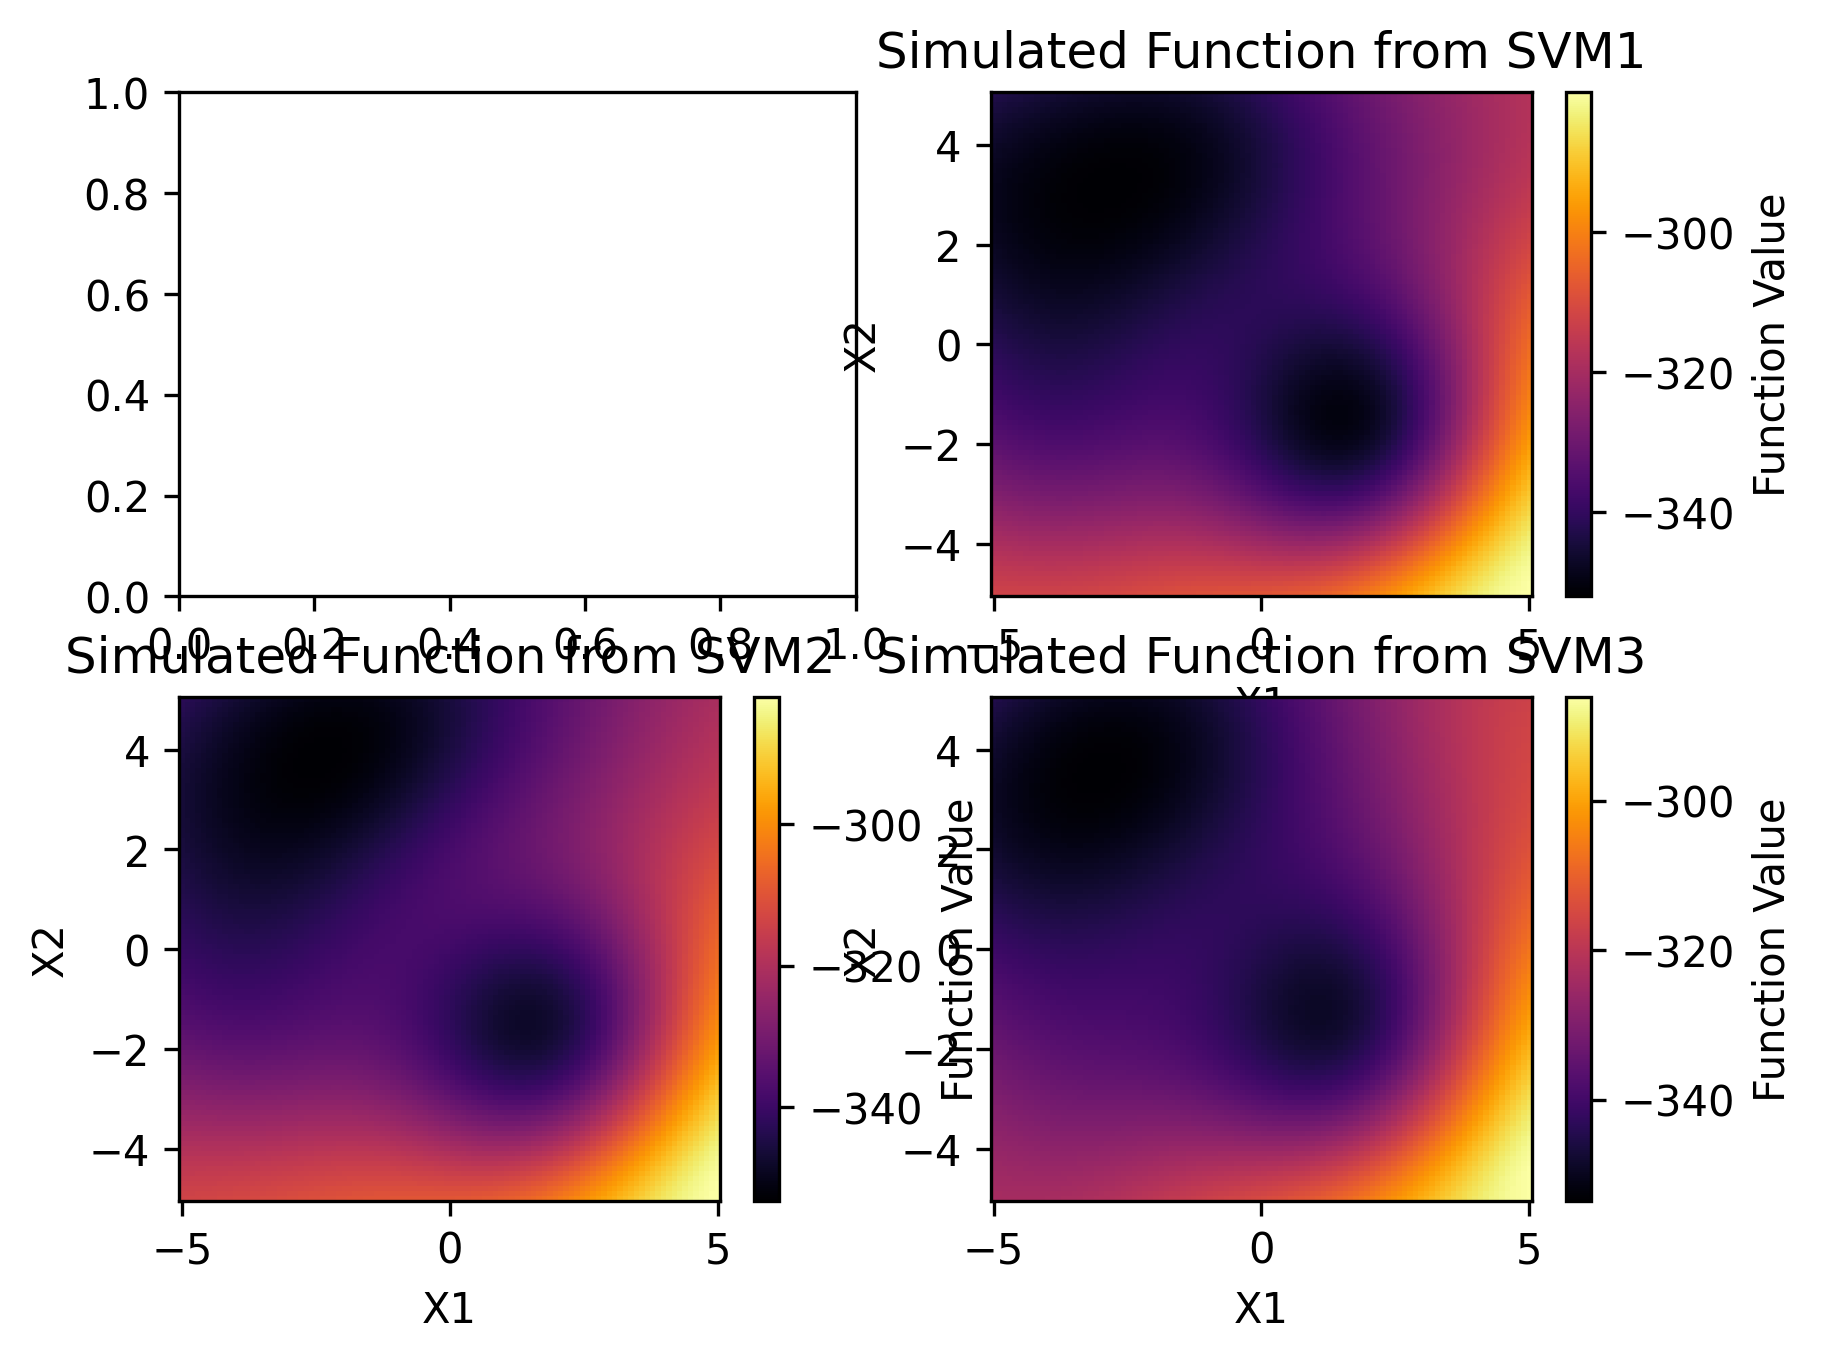

In [ ]:
plt.subplot(221)

plt.subplot(222)
plot_simulated_meshgrid(X, Y, mesh_results1, model='SVM1')
plt.subplot(223)
plot_simulated_meshgrid(X, Y, mesh_results2, model='SVM2')
plt.subplot(224)
plot_simulated_meshgrid(X, Y, mesh_results3, model='SVM3')
plt.gcf().set_dpi(300)
plt.show()

## SVM with gradient estimation

### Simple estimation with nearest neighbor from training data

In [ ]:
def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2)) ** 2))

def nearest_point(x1, x2, point_set):
    min_distance = float('inf')
    nearest_point = None
    
    for point in point_set:
        distance = euclidean_distance([x1, x2], point)	
        if distance < min_distance:
            min_distance = distance
            nearest_point = point
    
    return nearest_point

def nearest_point_with_target(x1, x2, point_set, target):
    min_distance = float('inf')
    nearest_point = None
    target_value = None
    
    for point, target_val in zip(point_set, target):
        distance = euclidean_distance([x1, x2], point)	
        if distance < min_distance:
            min_distance = distance
            nearest_point = point
            target_value = target_val
    
    return nearest_point, target_value

In [ ]:
data = sample_f24
problem = problem_f24
X_input = torch.tensor(data[0], dtype=torch.float32).clone().detach()
X_input_grad1 = torch.tensor(np.concatenate((X_input, data[2]), axis=1), dtype=torch.float32).clone().detach()
X_input_grad2 = torch.tensor(np.concatenate((X_input, data[2], data[3]), axis=1), dtype=torch.float32).clone().detach()
y_input = data[1].float()   

In [ ]:
nearest_point_with_target(-1, 1, X_input_grad1[:, 0:2], X_input_grad1[:, 2:4])

(tensor([-1.0150,  1.1585]), tensor([671.3867, 946.0449]))

In [ ]:
gt_sampling.get_gradient(problem, torch.tensor(np.array([-1, 1]).reshape((1, 2)), dtype=torch.float32))

[-408.935546875, -668.3349609375]

--> Fazit: ist kacke

In [ ]:
svr1.fit(X_input, y_input)
svr2.fit(X_input_grad1, y_input)
svr3.fit(X_input_grad2, y_input);

In [ ]:
from tqdm import tqdm

In [ ]:
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)

gradients_x = np.zeros_like(X)
gradients_y = np.zeros_like(Y)

gradients2_x = np.zeros_like(X)
gradients2_y = np.zeros_like(Y)

# Iterate through each point in the mesh grid and estimate gradients
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[1]):
        gradients_x[i, j], gradients_y[i, j] = nearest_point_with_target(X[i, j], Y[i, j], X_input_grad1[:, 0:2], X_input_grad1[:, 2:4])[1]
        
mesh_samples = np.c_[X.ravel(), Y.ravel(), gradients_x.ravel(), gradients_y.ravel()] 
mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
mesh_results1 = svr1.predict(mesh_samples_tensor[:, 0:2]).reshape(X.shape)
mesh_results2 = svr2.predict(mesh_samples_tensor[:, 0:4]).reshape(X.shape)

100%|██████████| 100/100 [02:20<00:00,  1.40s/it]


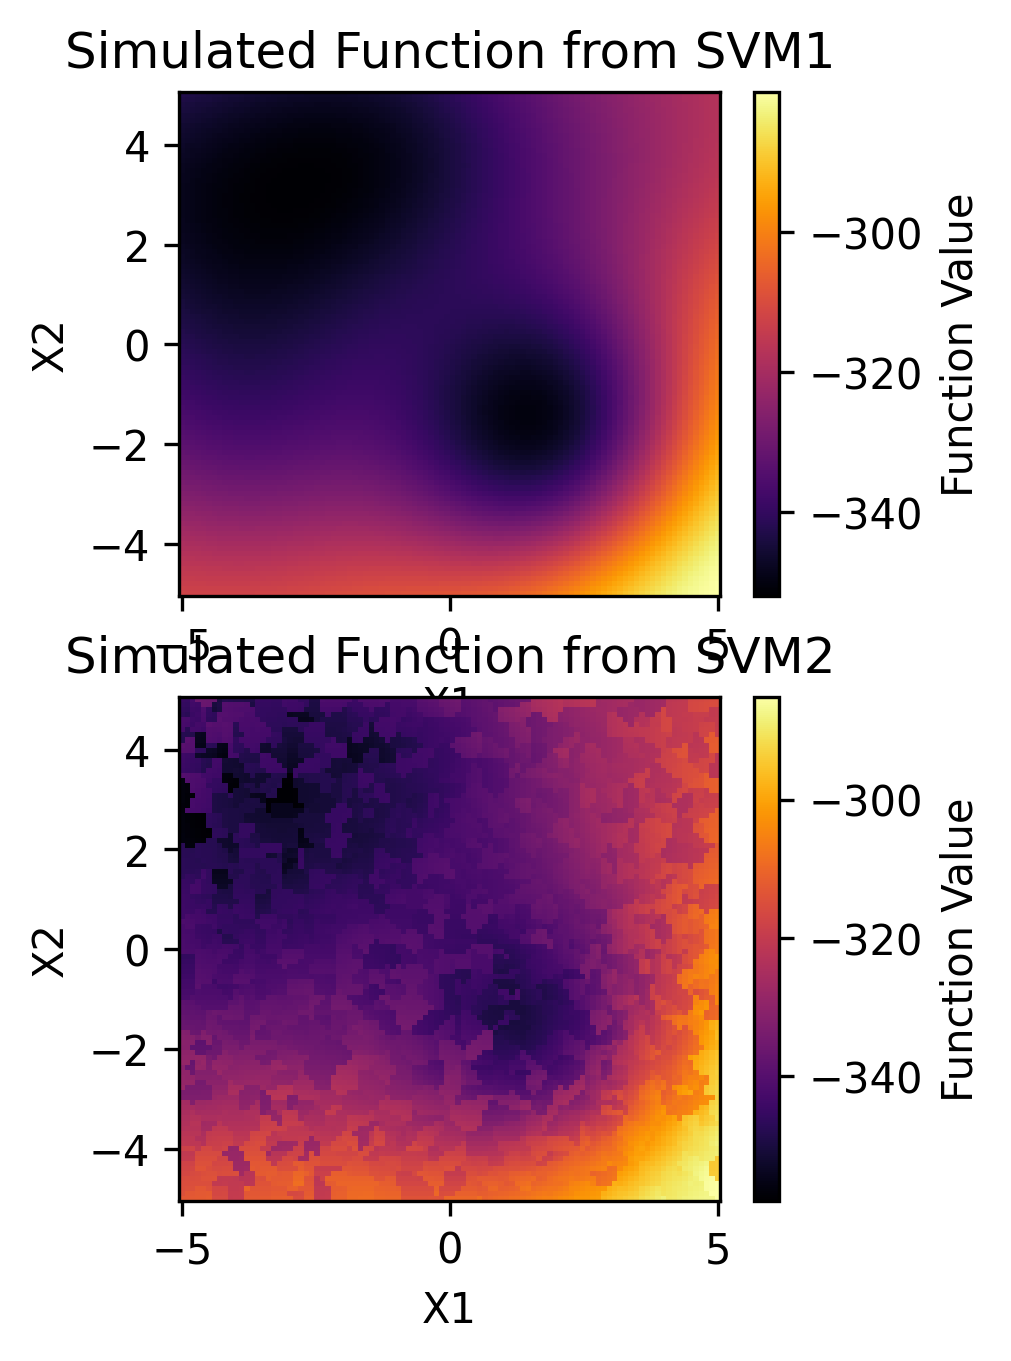

In [ ]:
plt.subplot(221)
plot_simulated_meshgrid(X, Y, mesh_results1, model='SVM1')
plt.subplot(223)
plot_simulated_meshgrid(X, Y, mesh_results2, model='SVM2')
plt.gcf().set_dpi(300)
plt.show()

In [4]:
def test_function(X, X_train, X_train_grads, model):
    ''' X 2D array of shape (2, n) '''
    X_grads = np.zeros_like(X)
    for i in range(len(X)):
        X_grads[i, 0], X_grads[i, 1] = nearest_point_with_target(X[i,0], X[i,1], X_train, X_train_grads)[1]
    
    X_in = np.concatenate((X, X_grads), axis=1)
    print(X_in.shape)

    return model.predict(X_in)

In [5]:
test_function(np.array([[2,3],[-4,0],[2.5,4.9]]), X_input, X_input_grad1[:,2:4], svr2)

NameError: name 'X_input' is not defined

In [ ]:
import os
FOLDER = os.path.join("../", "models")
if not os.path.exists(FOLDER):
    os.mkdir(FOLDER)

In [ ]:
import pickle

pickle.dump(svr2, open(f'{FOLDER}/SVM_grad.pkl', 'wb'))
pickle.dump(test_function, open(f'{FOLDER}/test_function.pkl', 'wb'))

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, ConstantKernel, Matern

In [ ]:
gradient_estimator = MultiOutputRegressor(GaussianProcessRegressor())

In [ ]:
gradient_estimator.fit(X_input_grad1[:,0:2], X_input_grad1[:,2:4])

MultiOutputRegressor(estimator=GaussianProcessRegressor())

In [ ]:
gradient_estimator.predict([[-1,1]])

array([[-291.67160225, -398.71865427]])

In [ ]:
gt_sampling.get_gradient(problem, torch.tensor(np.array([-1, 1]).reshape((1, 2)), dtype=torch.float32))

[-408.935546875, -668.3349609375]

In [ ]:
x = np.linspace(-5.0, 5.0, 100)
y = np.linspace(-5.0, 5.0, 100)
X, Y = np.meshgrid(x, y)

gradients_x = np.zeros_like(X)
gradients_y = np.zeros_like(Y)

gradients2_x = np.zeros_like(X)
gradients2_y = np.zeros_like(Y)

# Iterate through each point in the mesh grid and estimate gradients
for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[1]):
        gradients_x[i, j], gradients_y[i, j] = gradient_estimator.predict([[X[i, j], Y[i, j]]])[0]
        
mesh_samples = np.c_[X.ravel(), Y.ravel(), gradients_x.ravel(), gradients_y.ravel()] 
mesh_samples_tensor = torch.tensor(mesh_samples, dtype=torch.float32)
mesh_results1 = svr1.predict(mesh_samples_tensor[:, 0:2]).reshape(X.shape)
mesh_results2 = svr2.predict(mesh_samples_tensor[:, 0:4]).reshape(X.shape)

100%|██████████| 100/100 [00:13<00:00,  7.49it/s]


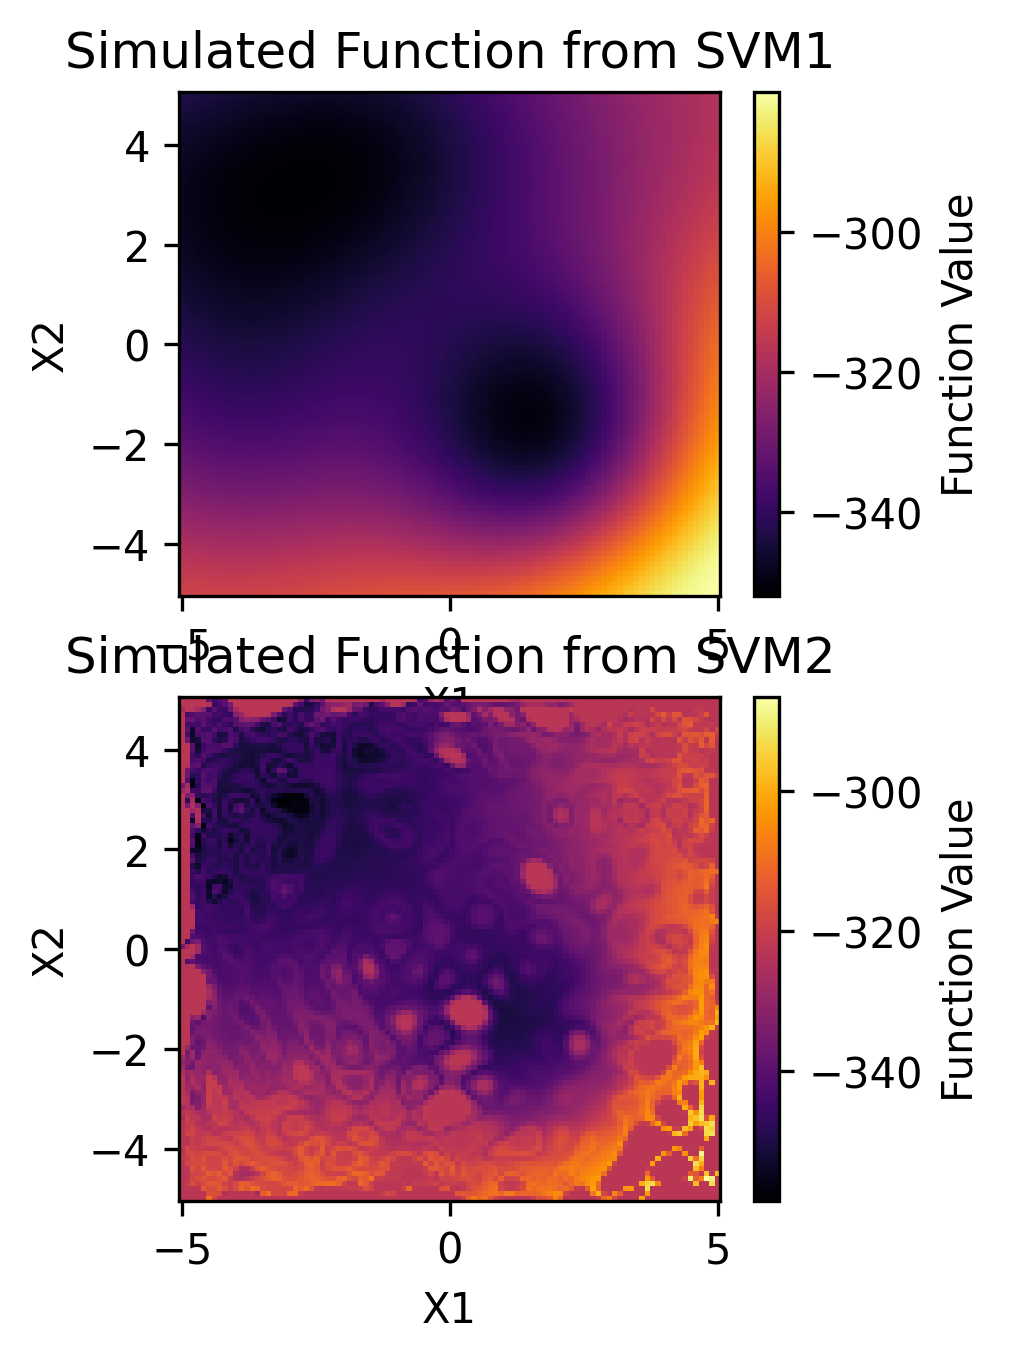

In [ ]:
plt.subplot(221)
plot_simulated_meshgrid(X, Y, mesh_results1, model='SVM1')
plt.subplot(223)
plot_simulated_meshgrid(X, Y, mesh_results2, model='SVM2')
plt.gcf().set_dpi(300)
plt.show()